In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from pyspark.sql import SparkSession

# Set random state for reproducibility
#random_state = 5
np.random.seed(5)


In [33]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Alzheimer's Disease Analysis") \
    .getOrCreate()

# Load the CSV file into a Spark DataFrame
file_path = "Resources/alzheimers_disease_data.csv"
alzheimers_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
alzheimers_df.printSchema()

# Convert to Pandas DataFrame
alzheimers_db = alzheimers_df.toPandas()

# Display basic information about the DataFrame
alzheimers_db.info()

# Display the first few rows of the DataFrame
alzheimers_db.head()


root
 |-- PatientID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- EducationLevel: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- AlcoholConsumption: double (nullable = true)
 |-- PhysicalActivity: double (nullable = true)
 |-- DietQuality: double (nullable = true)
 |-- SleepQuality: double (nullable = true)
 |-- FamilyHistoryAlzheimers: integer (nullable = true)
 |-- CardiovascularDisease: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Depression: integer (nullable = true)
 |-- HeadInjury: integer (nullable = true)
 |-- Hypertension: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- CholesterolTotal: double (nullable = true)
 |-- CholesterolLDL: double (nullable = true)
 |-- CholesterolHDL: double (nullable = true)
 |-- CholesterolTrig

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [34]:
# Separate target variable and features
X = alzheimers_db.drop(columns=['PatientID', 'Diagnosis', 'DoctorInCharge'])
y = alzheimers_db['Diagnosis']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Random Forest Accuracy: 0.9441860465116279
Random Forest Confusion Matrix:
 [[275   9]
 [ 15 131]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       284
           1       0.94      0.90      0.92       146

    accuracy                           0.94       430
   macro avg       0.94      0.93      0.94       430
weighted avg       0.94      0.94      0.94       430



<Figure size 1000x700 with 0 Axes>

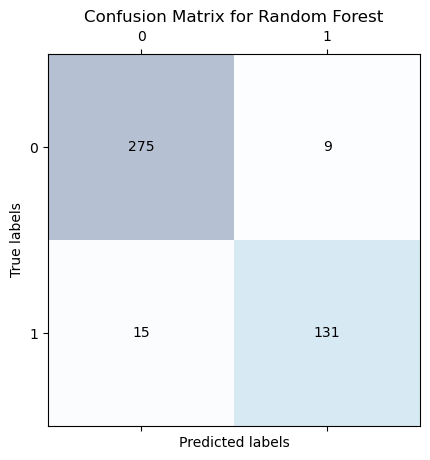

In [42]:
# Build Random Forest model
rf = RandomForestClassifier(random_state=5)
rf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

# Display results
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("Random Forest Classification Report:\n", class_report_rf)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(10, 7))
plt.matshow(conf_matrix_rf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_rf.shape[0]):
    for j in range(conf_matrix_rf.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix_rf[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


Decision Tree Accuracy: 0.8883720930232558
Decision Tree Confusion Matrix:
 [[252  32]
 [ 16 130]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       284
           1       0.80      0.89      0.84       146

    accuracy                           0.89       430
   macro avg       0.87      0.89      0.88       430
weighted avg       0.89      0.89      0.89       430



<Figure size 1000x700 with 0 Axes>

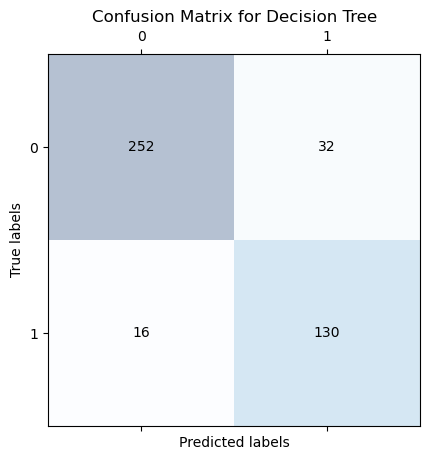

In [43]:
# Build Decision Tree model
dt = DecisionTreeClassifier(random_state=5)
dt.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt)

# Display results
print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Confusion Matrix:\n", conf_matrix_dt)
print("Decision Tree Classification Report:\n", class_report_dt)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(10, 7))
plt.matshow(conf_matrix_dt, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_dt.shape[0]):
    for j in range(conf_matrix_dt.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix_dt[i, j], va='center', ha='center')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


### ROC (Receiver Operating Characteristic) Curve and AUC (Area Under the Curve)
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. The Area Under the Curve (AUC) measures the entire two-dimensional area underneath the entire ROC curve.

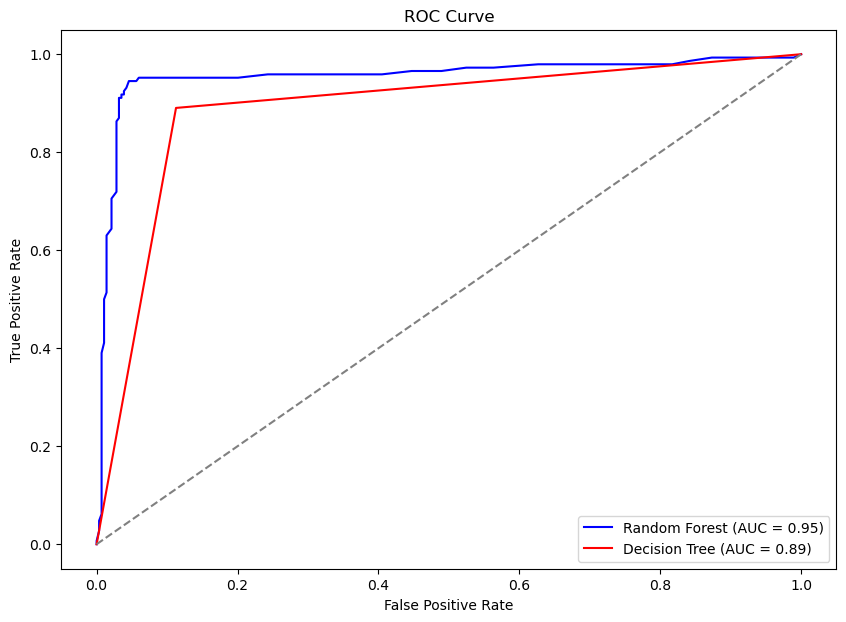

Random Forest AUC: 0.9549971059232104
Decision Tree AUC: 0.8888674512830408


In [44]:
# Compute ROC curve and AUC for Random Forest
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Compute ROC curve and AUC for Decision Tree
y_prob_dt = dt.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
auc_dt = roc_auc_score(y_test, y_prob_dt)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, color='red', label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Random Forest AUC:", auc_rf)
print("Decision Tree AUC:", auc_dt)


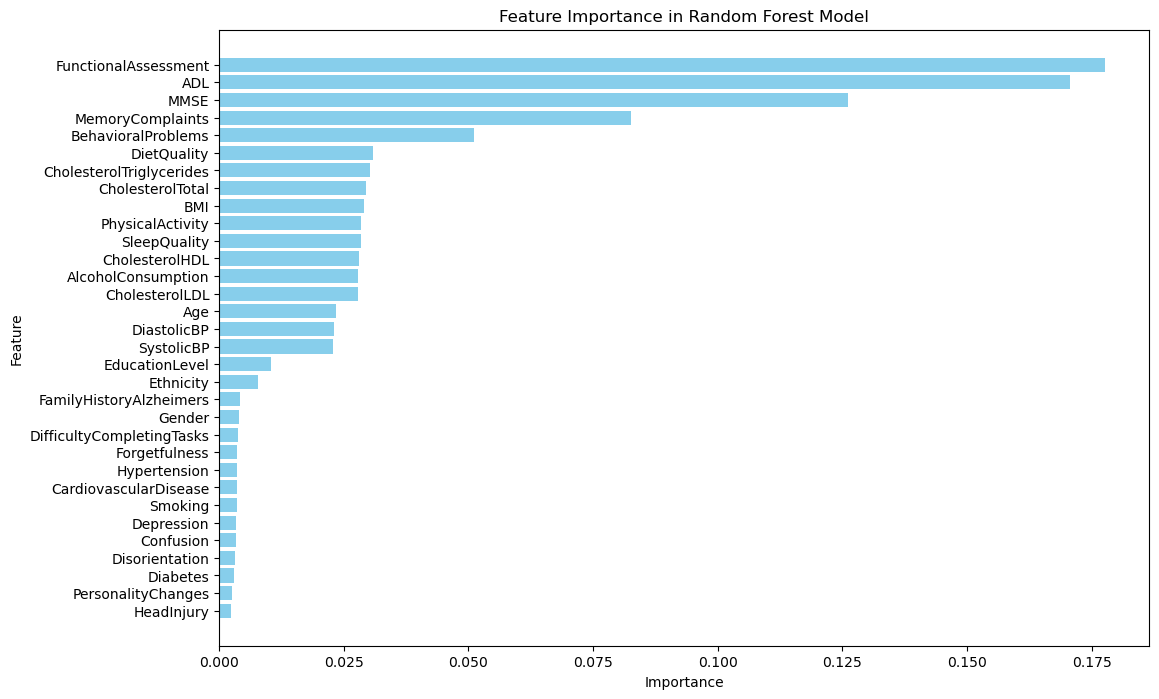

In [45]:
# Feature importance for Random Forest
importance_rf = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importance
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_rf
})

# Sort the DataFrame by importance
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Plot the feature importance for Random Forest
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


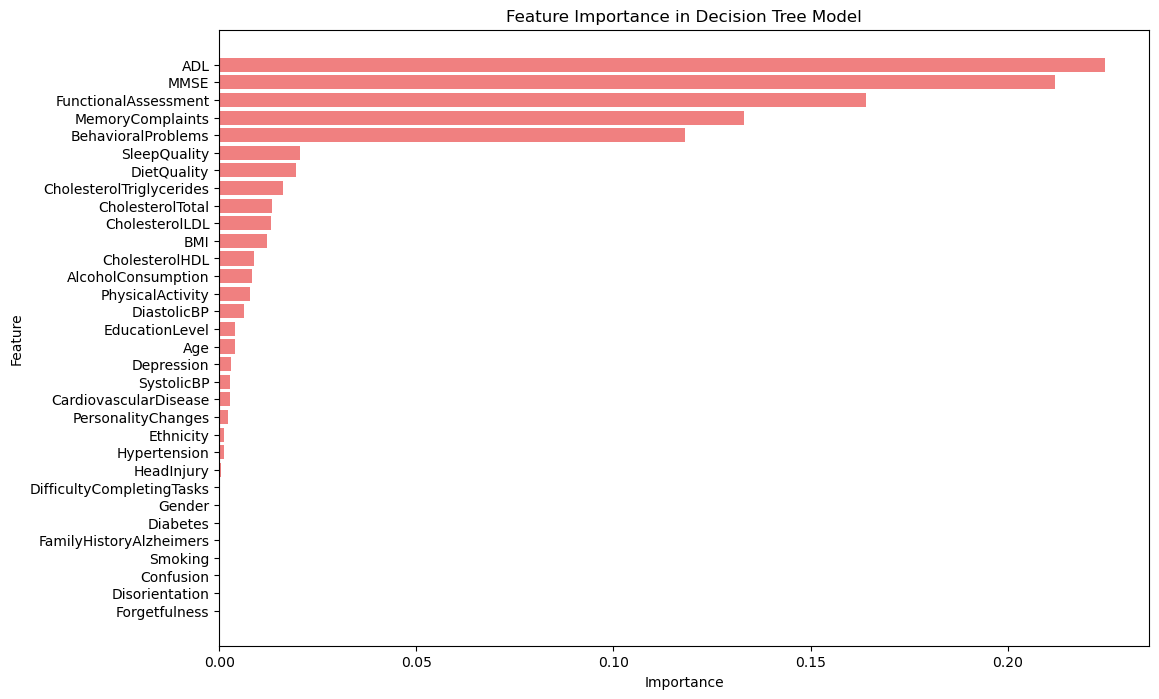

In [46]:
# Feature importance for Decision Tree
importance_dt = dt.feature_importances_
feature_importance_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_dt
})

# Sort the DataFrame by importance
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

# Plot the feature importance for Decision Tree
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_dt['Feature'], feature_importance_df_dt['Importance'], color='lightcoral')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()


In [47]:
import csv

# Create a CSV file to document model performance changes
with open('model_optimization_log.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Model", "Parameters", "Accuracy", "AUC"])

    # Example of logging changes (assuming iterative optimization)
    parameter_grid = [
        {"n_estimators": 100, "max_depth": 10},
        {"n_estimators": 200, "max_depth": 15},
        {"n_estimators": 300, "max_depth": 20}
    ]

    for i, params in enumerate(parameter_grid):
        # Train model with new parameters
        model = RandomForestClassifier(**params)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_prob)

        # Log results
        writer.writerow([i + 1, "Random Forest", str(params), accuracy, auc])


In [48]:
# Overall model performance display
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest AUC:", auc_rf)
print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree AUC:", auc_dt)


Random Forest Accuracy: 0.9441860465116279
Random Forest AUC: 0.9549971059232104
Decision Tree Accuracy: 0.8883720930232558
Decision Tree AUC: 0.8888674512830408
